In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.model_fpgan import FPGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("D:/Datasets/cardiovascular/cardio.csv",sep=";")
data = data.drop(columns=['id'])
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
data.shape

(70000, 12)

In [5]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())

In [6]:
target = 'cardio'

In [7]:
X = data.drop(columns=[target])
y = data[target]

In [8]:
model_ctgan = FPGANSynthesizer(epochs=10, verbose=True)
losses, tranformed_privacies = model_ctgan.fit(data)

Epoch 1, Loss G: -0.2739,Loss D:  0.1512
Epoch 2, Loss G: -0.0323,Loss D: -0.0710
Epoch 3, Loss G:  0.2491,Loss D: -0.1560
Epoch 4, Loss G: -0.0772,Loss D: -0.1003
Epoch 5, Loss G: -0.2384,Loss D: -0.0460
Epoch 6, Loss G: -0.1513,Loss D: -0.1079
Epoch 7, Loss G: -0.5410,Loss D:  0.1480
Epoch 8, Loss G:  0.2330,Loss D:  0.0498
Epoch 9, Loss G: -0.1608,Loss D: -0.1355
Epoch 10, Loss G:  0.4616,Loss D:  0.0042


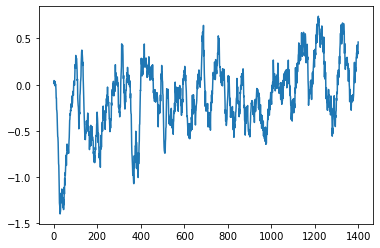

In [9]:
plt.plot(losses)
plt.show()

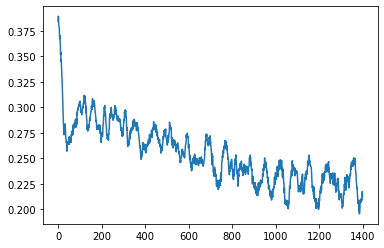

In [10]:
plt.plot(tranformed_privacies)
plt.show()

In [11]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [12]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [13]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.02248633]


## Fidelity

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test)

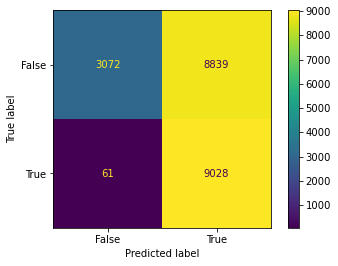

In [15]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [16]:
percentage, same_pred, dif_pred = eval_fidelity(rr_pred, fr_pred)

In [17]:
print(same_pred, dif_pred)

12100 8900


## Final plot

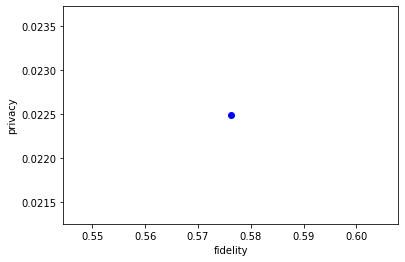

In [18]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()